## Abstract/Objetivo
<small> Conocer la variación de precios de los distintos productos publicados por la Unidad de Defensa del Consumidor de Uruguay. Comparar esta información con el IPC general publicado por el Instituto de Estadística (INE) a modo de verificar si hay un desvio o no entre ambos indicadores. Conocer ésto implica tener un indicio fuerte de si el IPC es el reflejo del incremento de precios percibido por el público en general.
</small>

#### Contexto Comercial
<small>
Siempre ha existido una percepción del público que la inflación se da en forma desigual en el país, y particularmente en la capital Montevideo que concentra la mitad de la población. Desde el año 2017 la Unidad de Defensa del Consumidor, dependiente del Ministerio de Economía publica mensualmente un boletín con precios diarios proporcionado por comercios que hacen parte de las mayores cadenas de supermercados y otros comercios minoristas.
</small>

#### Problema Comercial
<small>
Anualmente la AGESIC (Agencia del Gobierno Electrónico y Sociedad de la Infomación y de Conocimiento) a través de su portal (https://catalogodatos.gub.uy) pública esta lista de precios. Esta información es remitida diariamente por unos 400 a 600 comercios y comprende unos 300 productos. Esto hace que a la fecha haya más de 100 millones de registros en los 5 años que lleva publicado dicha información. En un contexto de inflación relativamente estable y debido al volúmen de dicha información he decidido que no es necesario trabajar con toda la data ya que la variación diaria de los precios no es relevante, con lo que se plantea un trabajo con óptica mensual/semestral/anual. <br>
A la vez se intentará enriquecer el análisis con el cruce de datos proveniente de otros organismos, como es la Encuesta Continua de Hogares (ECH) publicada mensualmente por el mismo INE. Se agrega el diccionario de datos de la encuesta (PDF), que es verdaderamente importante. <br>
Como punto fuerte hay que mencionar que el análisis permitirá al usuario incluir variables de su interés a efectos de comparar la variación de precios de comercios e IPC. Variables tan disímiles como precio de combustibles, cotización del dólar, población activa, etc., es decir, teóricamente cualquier variable. Esto con incluir los valores "a mano" en un archivo excel de "productos" especiales.
<br>
<br>
<br>
A lo largo del análisis se muestra donde se responde a las preguntas o donde está el indicio de respuesta, ya que se puede profundizar bastante más en cada punto.
</small>

#### Preguntas e hipótesis generales
<small>
-> Pregunta: Hay una percepción general de que los precios suben más que la inflación oficial, ¿ ésto es así ?
<br>
   Hipótesis: la inflación general está por debajo de la suba de precios en los comercios
<br>
-> Pregunta: La suba de los precios se da igual en todos las ciudades y barrios ?
<br>
   Hipótesis: La suba se da desigual, más alto en los barrios de ciudades de mayor poder adquisitivo
<br>
-> Pregunta: Las cadenas de comercios suben los precios por igual
<br>
   Hipótesis: Algunas suben bastante más que la otras
<br>
-> Pregunta: Hay alguna variable macroeconómica que refleje la suba de precios
<br>
   Hipótesis: Puede existir, difícil conocerla, si esto es así por lo menos conocer cierta correlación entre ellas.
<br>
-> Pregunta: Dado un contexto inflacionario estimado, es posible proyectar precios para productos o grupo de productos
<br>
   Hipótesis: Es posible, si bien la respuesta vendrá dada por las próximas publicaciones
<br><br><br>
Luego de conocer esta data se intentará aplicar un modelo de clasificación para predecir el incremento de precios respecto a la inflación.
</small>

### Módulos necesarios


In [1]:
import datetime
start_time = datetime.datetime.now()
print("Inicio de la ejecución:", start_time)

Inicio de la ejecución: 2023-10-22 19:42:07.415650


In [2]:
### Algunos módulos necesarios
import pandas as pd
import numpy as np
import calendar

from IPython.display import HTML

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn.linear_model import LinearRegression
from sklearn import linear_model

from sklearn.metrics import mean_squared_error
from sklearn.metrics import silhouette_score

from sklearn.cluster import KMeans

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.datasets import make_moons
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics.pairwise import haversine_distances
from sklearn.neighbors import KNeighborsClassifier

from scipy.stats import norm

from math import radians
from PIL import Image

import folium
from folium.plugins import HeatMap

import warnings # Para ignorar algunas advertencias, "futurewarning", etc.

### Variables de contexto

In [3]:
### Variables de contexto
v_MesesContexto = [6, 12]                                # deben estar en orden ascendente
v_AñosContexto = [2017,2018,2019,2020,2021,2022,2023]   # deben estar en orden ascendente

v_AnoMes_Filtro = [x * 100 + y for x in v_AñosContexto for y in v_MesesContexto]
v_AnoMes_FiltroR = v_AnoMes_Filtro[1:]  # Excluyo el primer año por valores nulos y "1"

v_AnoMes_Ultimo = [max(v_AnoMes_FiltroR)]  # Para analizar el periodo completo

v_ultimo_DiaMes = []
for v_Año in v_AñosContexto:
    for v_Mes in range(1, 13):
        v_ultimo_Dia = calendar.monthrange(v_Año, v_Mes)[1]
        v_FechaTmp = datetime.date(v_Año, v_Mes, v_ultimo_Dia)
        v_ultimo_DiaMes.append(v_FechaTmp)
del v_FechaTmp

# Por simplicidad en el algoritmo, si existen, los nuevos datos los incluyo en el cálculo general
v_excluye_NuevosDatos = [202306, 202312]  # Para excluir los meses con datos nuevos, si no existen o no se publicaron indicar próxima fecha

warnings.filterwarnings('ignore')

### Descarga de archivo de Precios Principal


In [4]:
# Importación del archivo de precios previamente procesado, en este caso tomo los meses 6 y 12 (semestral)

dtype_dict = {'Precio': 'float32'}

# Todos los meses
#df_Precios = pd.read_csv(v_ruta + '/Arch_Precios_Paso0.csv', parse_dates=['Fecha'],  header=None, names= ['Id_PrDiario', 'Fecha', 'Fecha_Ant', 'Oferta', 'Pr_desuso', 'Precio', 'Anulada1', 'Anulada2', 'id_Estab', 'id_Ferias', 'id_Producto' ], dtype=dtype)

# Analisis para meses 6 y 12
v_rutaWeb_Precios = "https://raw.githubusercontent.com/slotito/PreciosUy_v0/main/Arch_Precios_Paso1_06y12.csv"
df_Precios0a = pd.read_csv(v_rutaWeb_Precios, sep=',', decimal='.', dtype=dtype_dict, parse_dates=['Fecha'])

v_rutaWeb_PreciosPost = "https://raw.githubusercontent.com/slotito/PreciosUy_v0/main/Arch_Precios_Paso1_06_2023.csv"
df_PreciosPost = pd.read_csv(v_rutaWeb_PreciosPost, sep=',', decimal='.', dtype=dtype_dict, parse_dates=['Fecha'])

df_Precios0 = pd.concat([df_Precios0a, df_PreciosPost], ignore_index=True)

del v_rutaWeb_Precios, dtype_dict  # limpieza de variables innecesarias
print("Actual cantidad de registros en df precios: ", df_Precios0.shape[0])

Actual cantidad de registros en df precios:  3243789


##### Cálculos previos

In [5]:
# Calculos para el Dataframe prncipal

df_Precios1 = df_Precios0[df_Precios0['Fecha'].isin(v_ultimo_DiaMes)]

df_Precios1['Fecha'] =  pd.to_datetime(df_Precios1['Fecha'], format='%Y/%m/%d')
df_Precios1['Año'] = df_Precios1['Fecha'].dt.year
df_Precios1['Mes'] = df_Precios1['Fecha'].dt.month
df_Precios1['Cod_AnoMes'] = (df_Precios1['Fecha'].dt.year * 100) + df_Precios1['Fecha'].dt.month  # LLave para el merge

# Me aseguro que cada producto y comercio tenga solamente un precio por mes
df_Precios1 = df_Precios1.groupby(['id_Producto' , 'id_Estab','Cod_AnoMes', 'Año', 'Mes'])['Precio'].mean().reset_index()

### Me aseguro que estos campos tengan el tipo de dato correcto
df_Precios1.loc[:, 'id_Estab'] = df_Precios1['id_Estab'].astype('int16')
df_Precios1.loc[:, 'id_Producto'] = df_Precios1['id_Producto'].astype('int16')
df_Precios1 = df_Precios1[df_Precios1['Cod_AnoMes'].isin(v_AnoMes_Filtro)]
del df_Precios0

print("Actual cantidad de registros en df precios: ", df_Precios1.shape[0])


Actual cantidad de registros en df precios:  602509


↓↓↓ <small> Eliminación de valores nulos </small> ↓↓↓

In [6]:
# Dataframes auxiliares para el análisis
# Voy dejando la ruta de dataframes anteriores para poder volver atras si es necesario
df_Precios2 = df_Precios1.copy()
df_Precios2.replace(0, np.nan, inplace=True)
df_Precios2.dropna(axis=0, how='any', inplace=True) # Elimina las filas con NaN en cualquier columna
#del df_Precios1
print("Actual cantidad de registros en df precios: ", df_Precios2.shape[0])


Actual cantidad de registros en df precios:  601152


### Descarga de archivos secundarios

In [7]:
# Dataframe auxiliar de comercios

dtype_dict = {'depto': 'category', 'cadena': 'category'}

v_rutaWeb_Establecimiento = "https://raw.githubusercontent.com/slotito/PreciosUy_v0/main/establecimiento.csv"
df_Establecimientos = pd.read_csv(v_rutaWeb_Establecimiento, sep=';', decimal=',', dtype=dtype_dict)
del v_rutaWeb_Establecimiento
df_EstablecimientosRes = df_Establecimientos[['id_establecimientos', 'cadena', 'id.depto', 'depto', 'cajas', 'long', 'lat']]
df_EstablecimientosRes = df_EstablecimientosRes.rename(columns={'id_establecimientos': 'id_Estab', 'id.depto': 'id_depto'})
df_EstablecimientosRes = df_EstablecimientosRes.drop_duplicates()

df_EstablecimientosRes['lat'] = df_EstablecimientosRes['lat'].str.replace(',', '.')
df_EstablecimientosRes['long'] = df_EstablecimientosRes['long'].str.replace(',', '.')
df_EstablecimientosRes['lat'] = pd.to_numeric(df_EstablecimientosRes['lat'], errors='coerce')
df_EstablecimientosRes['long'] = pd.to_numeric(df_EstablecimientosRes['long'], errors='coerce')
df_EstablecimientosRes['lat_rad'] = np.radians(df_EstablecimientosRes['lat'])
df_EstablecimientosRes['lon_rad'] = np.radians(df_EstablecimientosRes['long'])
df_EstablecimientosRes.loc[df_EstablecimientosRes['lat'] > 0, 'lat'] = df_EstablecimientosRes.loc[df_EstablecimientosRes['lat'] > 0, 'lat'] * -1
df_EstablecimientosRes.loc[df_EstablecimientosRes['long'] > 0, 'long'] = df_EstablecimientosRes.loc[df_EstablecimientosRes['long'] > 0, 'long'] * -1

print("Cantidad de establecimientos: ", df_EstablecimientosRes.shape[0])

Cantidad de establecimientos:  761


In [8]:
# Dataframe auxiliar con los productos clasificados

# Los category los tengo que establecer de antemano porque después no los toma bien
dtypes = {'Division': str, 'Grupo': str, 'Clase': 'category', 'Subclase': str, 'Producto': str}
v_rutaWeb_ProductosClasificados = 'https://github.com/slotito/PreciosUy_v0/blob/main/Productos_Clasificados.xlsx?raw=true'
df_ProductosClasificados = pd.read_excel(v_rutaWeb_ProductosClasificados, sheet_name='productos', header=0, engine='openpyxl', dtype=dtypes)

df_ProductosClasificadosReduc = df_ProductosClasificados[['id_Producto', 'Division', 'Grupo', 'Clase', 'Subclase']]
df_ProductosClasificadosReduc = df_ProductosClasificadosReduc.drop_duplicates()
del v_rutaWeb_ProductosClasificados, dtypes, df_ProductosClasificados
print("Cantidad de productos: ", df_ProductosClasificadosReduc.shape[0])

Cantidad de productos:  363


 ↓↓↓ <small> Cálculos previos </small> ↓↓↓

In [9]:
# Dataframe auxiliar de IPC y preparación de los datos

v_rutaWeb_IPCGralBase2022 = 'https://github.com/slotito/PreciosUy_v0/blob/main/IPC_gral_y_variaciones_base_2022.xls?raw=true'
df_ipcGral = pd.read_excel(v_rutaWeb_IPCGralBase2022, sheet_name='IPC_Cua 1', header=0, engine='xlrd' )

### Elimino las primeras filas del encabezado, algunas columnas innecesarias y nombro las columnas del dataframe
df_ipcGral = df_ipcGral.drop(df_ipcGral.index[0:8])
df_ipcGral.columns = [ 'Fecha', 'Indice', 'Ind_Var1', 'Ind_VarAño', 'Ind_Var12','Ind_Var3','Ind_Var4', 'Ind_Var6']

#tmp_col_elimina = ['eliminar2', 'eliminar3', 'eliminar4']
#df_ipcGral = df_ipcGral.drop(tmp_col_elimina, axis=1)
df_ipcGral = df_ipcGral.dropna(subset=['Indice'])

df_ipcGral['Fecha'] = pd.to_datetime(df_ipcGral['Fecha'])

# Creo un indice auxiliar 'Año/Mes' a fin de matchear con otros dataframes
df_ipcGral['Cod_AnoMes'] = (df_ipcGral['Fecha'].dt.year * 100) + df_ipcGral['Fecha'].dt.month

# Convierto algunos tipos de datos para asegurarme que tengan el tipo correcto
df_ipcGral['Indice'] = df_ipcGral['Indice'].astype(float)
df_ipcGral['Ind_Var1'] = df_ipcGral['Ind_Var1'].astype(float)
df_ipcGral['Ind_Var3'] = df_ipcGral['Ind_Var3'].astype(float)
df_ipcGral['Ind_Var6'] = df_ipcGral['Ind_Var6'].astype(float)
df_ipcGral['Ind_Var12'] = df_ipcGral['Ind_Var12'].astype(float)
df_ipcGral['Ind_VarAño'] = df_ipcGral['Ind_VarAño'].astype(float)

df_ipcGral = df_ipcGral[df_ipcGral['Cod_AnoMes'].isin(v_AnoMes_Filtro)]

df_ipcGral['Ind_Var'] = df_ipcGral['Indice'].pct_change(periods=1) * 100

### Elimino columna innecesaria, ya tengo el índice Año/Mes que usaré
df_ipcGral = df_ipcGral.drop(['Fecha', 'Ind_VarAño', 'Ind_Var1', 'Ind_Var3', 'Ind_Var6', 'Ind_Var12'], axis=1)

### Reordeno el DF
df_ipcGral = df_ipcGral.reindex(columns=['Cod_AnoMes' , 'Indice', 'Ind_Var'])



In [10]:
# Dataframe auxiliar de estructura de IPC

v_rutaWeb_EstructuraIPC = 'https://github.com/slotito/PreciosUy_v0/blob/main/Estructura_IPC.xlsx?raw=true'

df_IPC_Divisiones = pd.read_excel(v_rutaWeb_EstructuraIPC, sheet_name='Divisiones', header=0, engine='openpyxl', dtype={"Division": str})
df_IPC_Divisiones = df_IPC_Divisiones.loc[:, ["Division", "Denominación Division"]]
df_IPC_Divisiones.dropna(subset=['Division'], inplace=True)

df_IPC_Grupo = pd.read_excel(v_rutaWeb_EstructuraIPC, sheet_name='Grupo', header=0, engine='openpyxl', dtype={"Grupo": str})
df_IPC_Grupo = df_IPC_Grupo.loc[:, ["Grupo", "Denominación Grupo"]]
df_IPC_Grupo["Grupo"] = df_IPC_Grupo["Grupo"].astype(str).str[:3]
df_IPC_Grupo.dropna(subset=['Grupo'], inplace=True)

df_IPC_Clases = pd.read_excel(v_rutaWeb_EstructuraIPC, sheet_name='Clases', header=0, engine='openpyxl', dtype={"Clase": str})
df_IPC_Clases.dropna(subset=['Clase'], inplace=True)


#### Merge de archivos

<small>A continuación: <br>
Se "mergean" archivo de precios e IPC<br>
Se crean variables sintéticas surgidas de características ya existentes a fin de ampliar información</small>

In [11]:
# Le agrego la inflación al dataframe de precios
df_Precios3 = pd.merge(df_Precios2, df_ipcGral, on='Cod_AnoMes', how='left')
df_Precios4 = pd.merge(df_Precios3, df_ProductosClasificadosReduc, on='id_Producto', how='left')
df_Precios5 = pd.merge(df_Precios4, df_EstablecimientosRes, on='id_Estab', how='left')
del df_Precios2, df_Precios3, df_Precios4
print("Cantidad actual de registros: ", df_Precios5.shape[0])
print("Cantidad actual de columnas: ", df_Precios5.shape[1])


Cantidad actual de registros:  601152
Cantidad actual de columnas:  20


↓↓↓ <small>Se procede al armado de variables auxiliares del dataframe auxiliar</small> ↓↓↓

In [12]:
# Se agregan: variación de precios nominal y derivadas: variación % interperíodo y variación % acumulado
df_Precios5['Pre_VarMes'] = df_Precios5.groupby(['id_Producto', 'id_Estab'])['Precio'].diff()
df_Precios5['Pre_VarMesPor'] = df_Precios5['Pre_VarMes'] / (df_Precios5['Precio'] - df_Precios5['Pre_VarMes']) * 100
df_Precios5['Pre_VarAcu'] = df_Precios5.groupby(['id_Producto', 'id_Estab'])['Pre_VarMes'].cumsum()
df_Precios5['Pre_VarAcuPor'] = df_Precios5['Pre_VarAcu'] / (df_Precios5['Precio'] - df_Precios5['Pre_VarAcu']) * 100

# Idem que el anterior pero para el IPC
df_Precios5['Ind_VarMes'] = df_Precios5.groupby('id_Producto')['Indice'].diff()
df_Precios5['Ind_VarMesPor'] = df_Precios5['Ind_VarMes'] / (df_Precios5['Indice'] - df_Precios5['Ind_VarMes']) * 100
df_Precios5['Ind_VarAcu'] = df_Precios5.groupby('id_Producto')['Ind_VarMes'].cumsum()
df_Precios5['Ind_VarAcuPor'] = df_Precios5['Ind_VarAcu'] / (df_Precios5['Indice'] - df_Precios5['Ind_VarAcu']) * 100

# Variables sintéticas: variables que calcula la diferencia mensual y acumulado entre el precio y el IPC
df_Precios5['Pre_DifVarMesPor'] = ((df_Precios5['Pre_VarMesPor'] / df_Precios5['Ind_VarMesPor']) -1) * 100
df_Precios5['Pre_DifVarAcuPor'] = ((df_Precios5['Pre_VarAcuPor'] / df_Precios5['Ind_VarAcuPor']) -1) * 100

# Idem anterior pero en valor absoluto (ya que en algunos casos el valor porcentual distorsiona el cálculo de interés)
df_Precios5['Pre_DifVarMesPorAbs'] = (df_Precios5['Pre_VarMesPor'] - df_Precios5['Ind_VarMesPor']) 
df_Precios5['Pre_DifVarAcuPorAbs'] = (df_Precios5['Pre_VarAcuPor'] - df_Precios5['Ind_VarAcuPor'])

min_per = df_Precios5["Cod_AnoMes"].min()  # Periodo mínimo de la serie (base del cálculo)

#nuevo_orden_col = ['id_Producto', 'Cod_AnoMes', 'Año', 'Mes', 'Precio', 'Pre_VarMes', 'Pre_VarAcu', 'Indice', 'Ind_VarMes', 'Ind_VarAcu', 'Pre_VarMesPor', 'Ind_VarMesPor', 'Pre_DifVarMesPor', 'Pre_VarAcuPor', 'Ind_VarAcuPor', 'Pre_DifVarAcuPor']
print("Cantidad actual de registros: ", df_Precios5.shape[0])
print("Cantidad actual de columnas: ", df_Precios5.shape[1])


Cantidad actual de registros:  601152
Cantidad actual de columnas:  32


In [13]:
# Obtengo la cantidad de productos únicos por division para tener una visión del dataframe

v_prodUnicos = df_Precios5.groupby('Division')['id_Producto'].nunique().reset_index()
v_prodUnicos.rename(columns={'id_Producto': 'Cant Prod.únicos'}, inplace=True)
division_descrip = {
    '01': 'Alimentos y Bebidas no Alcohólicas',
    '02': 'Bebidas Alcohólicas, tabaco',
    '05': 'Mobiliario, enseres domésticos',
    '09': 'Recreación y Deporte',
    '11': 'Restaurantes y servicio alojam.',
    '13': 'Cuidado Personal, bienes diversos',
}
v_prodUnicos['Descripción Division'] = v_prodUnicos['Division'].map(division_descrip)
print(v_prodUnicos)

  Division  Cant Prod.únicos                Descripción Division
0       01               137  Alimentos y Bebidas no Alcohólicas
1       02                 6         Bebidas Alcohólicas, tabaco
2       05                12      Mobiliario, enseres domésticos
3       09                39                Recreación y Deporte
4       11                 6     Restaurantes y servicio alojam.
5       13                58   Cuidado Personal, bienes diversos


In [14]:
# Eliminación de valores infinitos (producto de la división por cero en algunos casos)
df_Precios5a = df_Precios5.copy()
df_Precios5a[df_Precios5a == np.inf] = np.nan
df_Precios5a[df_Precios5a == -np.inf] = np.nan
df_Precios5a = df_Precios5a.dropna(subset=['Pre_VarMes'])
del df_Precios5
print("Cantidad actual de registros: ", df_Precios5a.shape[0])

Cantidad actual de registros:  513386


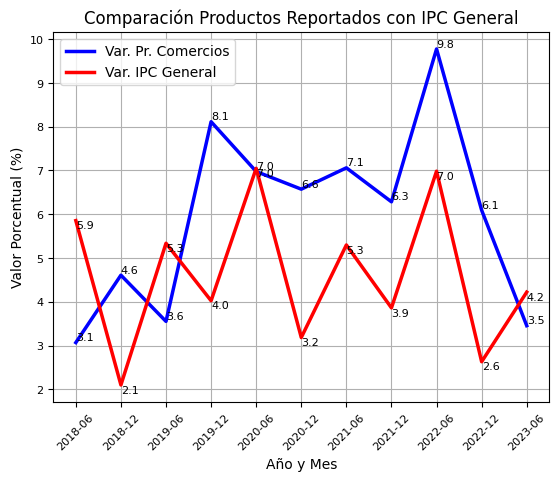

La diferencia media entre 'Precio en Comercios' e 'IPC General' es: 51%


In [15]:
df_Precios5b = df_Precios5a.groupby(['Cod_AnoMes', 'Año', 'Mes'])[['Pre_VarMesPor','Ind_VarMesPor']].mean().reset_index()

# Convierto el código de año y mes a texto para poder graficar
def convertir_a_texto(codigo_anomes):
    year = str(codigo_anomes // 100)
    month = str(codigo_anomes % 100).zfill(2)
    return f"{year}-{month}"

df_Precios5b['Cod_AnoMes_Texto'] = df_Precios5b['Cod_AnoMes'].apply(convertir_a_texto)

plt.plot(df_Precios5b['Cod_AnoMes_Texto'], df_Precios5b['Pre_VarMesPor'], label='Productos Analizados', linewidth=2.5, color='blue')
plt.plot(df_Precios5b['Cod_AnoMes_Texto'], df_Precios5b['Ind_VarMesPor'], label='IPC General', linewidth=2.5, color='red')

for index, row in df_Precios5b.iterrows():
    plt.text(row['Cod_AnoMes_Texto'], row['Pre_VarMesPor'], f'{row["Pre_VarMesPor"]:.1f}', fontsize=8, va='bottom')
    plt.text(row['Cod_AnoMes_Texto'], row['Ind_VarMesPor'], f'{row["Ind_VarMesPor"]:.1f}', fontsize=8, va='top')

plt.xlabel('Año y Mes')
plt.ylabel('Valor Porcentual (%)')
plt.title('Comparación Productos Reportados con IPC General')
plt.legend(['Var. Pr. Comercios', 'Var. IPC General'])

plt.xticks(rotation=45)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.grid(True)
plt.show()

# Determinación de la diferencia media entre los precios y el IPC
df_Precios5c = df_Precios5b[df_Precios5b['Cod_AnoMes'] > 201912]
df_Precios5c['Diferencia'] = ((df_Precios5c['Pre_VarMesPor']*100) / (df_Precios5c['Ind_VarMesPor']*100))-1
diferencia_media = df_Precios5c['Diferencia'].mean() *100
print(f"La diferencia media entre 'Precio en Comercios' e 'IPC General' es: {diferencia_media:.0f}%")

↑↑↑ <small>
La realidad parece darle la razón a la sensación general de una inflación por debajo del incremento en los comercios.<br>
Desde el segundo semestre del año 2020 se observa una suba de precios en los comercios que no se refleja en el IPC, siendo claramente mayor.<br>
La propuesta es acotar el análisis a partir de un momento próximo a esta fecha con lo que se tomarán los últimos 6 semestres (trienio 2020-20212) para el análisis.<br>
Entonces, dicha diferencia es de un 62% (si se excluye el primer semestre 2023, información publicada posteriormente), claro está, en un contexto de inflación relativamente baja, pero que no deja de ser significativa.<br>
</small>

In [16]:
df_Precios6 = df_Precios5a[df_Precios5a['Cod_AnoMes'] > 201912]
v_AñosContextoR = [2020,2021,2022]   # Se redefinen los años de contexto para el análisis
print("Cantidad actual de registros: ", df_Precios6.shape[0])

Cantidad actual de registros:  328568


In [17]:
# Dataframes auxiliares para otros análisis

# Calculos para el Dataframe de precios por producto (Excluyendo el comercio)
df_Precios6p = df_Precios6.groupby(['id_Producto', 'Cod_AnoMes', 'Año', 'Mes'])[['Precio', 'Pre_VarAcuPor', 'Ind_VarAcuPor']].mean().reset_index()

# Calculos para el Dataframe de precios por establacimiento (Excluyendo el producto)
df_Precios6e = df_Precios6.groupby(['id_Estab', 'Cod_AnoMes', 'Año', 'Mes'])[['Precio', 'Pre_VarAcuPor', 'Ind_VarAcuPor' ]].mean().reset_index()


#### Visualización de outliers
↓↓↓ <small>Se propone el siguiente gráfico con la finalidad de tener una vista rápida de datos outliers de cada producto<br>
Importante notar que en este momento no interesa la detección del outlier de un producto en particular</small>

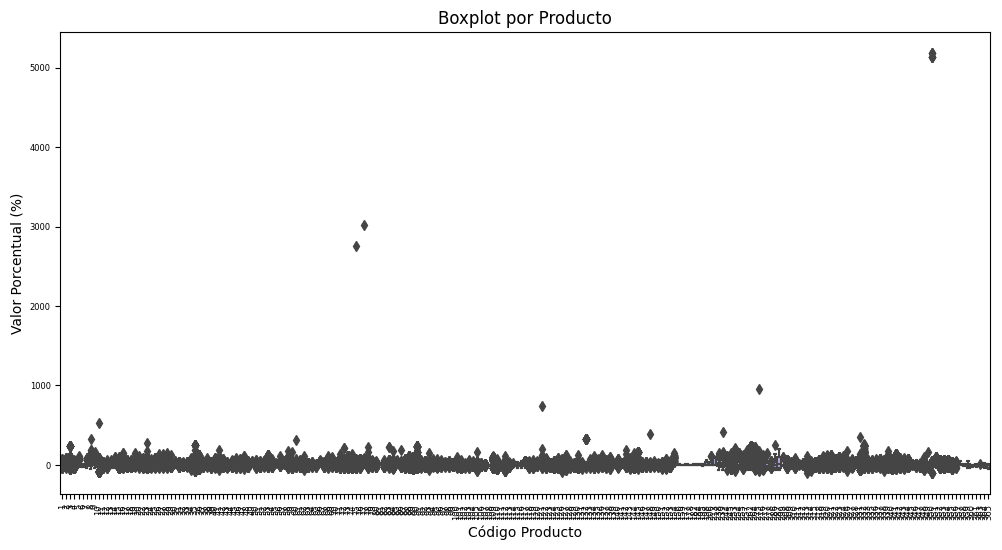

In [18]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='id_Producto', y='Pre_DifVarMesPorAbs', data=df_Precios6)
plt.xticks(fontsize=6)
plt.yticks(fontsize=6)
plt.xticks(rotation=90)
plt.xlabel('Código Producto')
plt.ylabel('Valor Porcentual (%)')
plt.title('Boxplot por Producto')
plt.show()

 #### ↓↓↓ Eliminación de outliers  ↓↓↓
<small>Medida discrecional<br>
En contexto de precios relativamente estables, se considera que un producto que sube más de un 300% en seis meses es un outlier.
</small>


In [19]:
df_Precios6t = df_Precios6[(df_Precios6['Pre_DifVarMesPorAbs'] < 300)]
print("Cantidad actual de registros: ", df_Precios6t.shape[0])

Cantidad actual de registros:  328515


##### Se propone una visualización de la variación de precios de los productos según el precio de venta en valor absoluto del mismo<br>
<small>Esto permite una rápida visualización de la variación respecto a la inflación según el precio del producto</small>

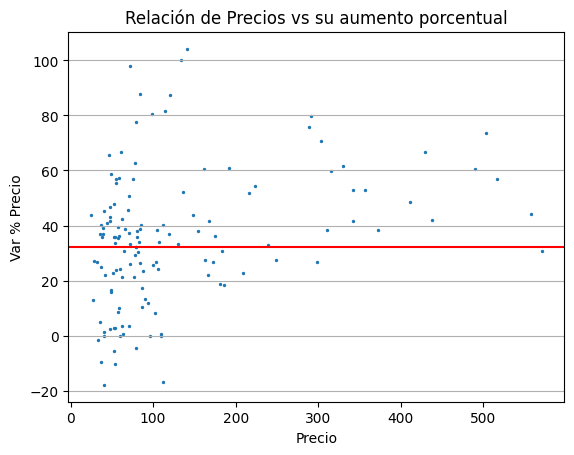

In [20]:
v_Division = ['01']
df_Precios6t_tmp = df_Precios6t[(df_Precios6t['Division'].isin(v_Division)) ]
df_Precios6t_tmp2 = df_Precios6t_tmp.groupby('id_Producto')[['Precio', 'Pre_VarAcuPor']].mean()
v_PromIPC = df_Precios6t_tmp['Ind_VarAcuPor'].mean()
plt.axhline(y=v_PromIPC, color='red', linestyle='-')

plt.scatter(df_Precios6t_tmp2['Precio'],df_Precios6t_tmp2['Pre_VarAcuPor'] ,s=2)
plt.xlabel('Precio')
plt.ylabel('Var % Precio')
plt.gca().yaxis.grid(True)
plt.title('Relación de Precios vs su aumento porcentual')
plt.show()

↑↑↑ <small>Insight: los producto de menor valor tienen una dispersión bastante equidistante respecto a la inflación, los productos de más alto valor por su parte han tenido una variación mayor a la inflación.<br>
Esto puede anticipar una precisión media en los modelos a la hora de clasificar los productos en función de su variación respecto a la inflación.</small> ↑↑↑ 

↓↓↓ <small>Visualización de la distribución normal de las variación de precios vs IPC</small> ↓↓↓

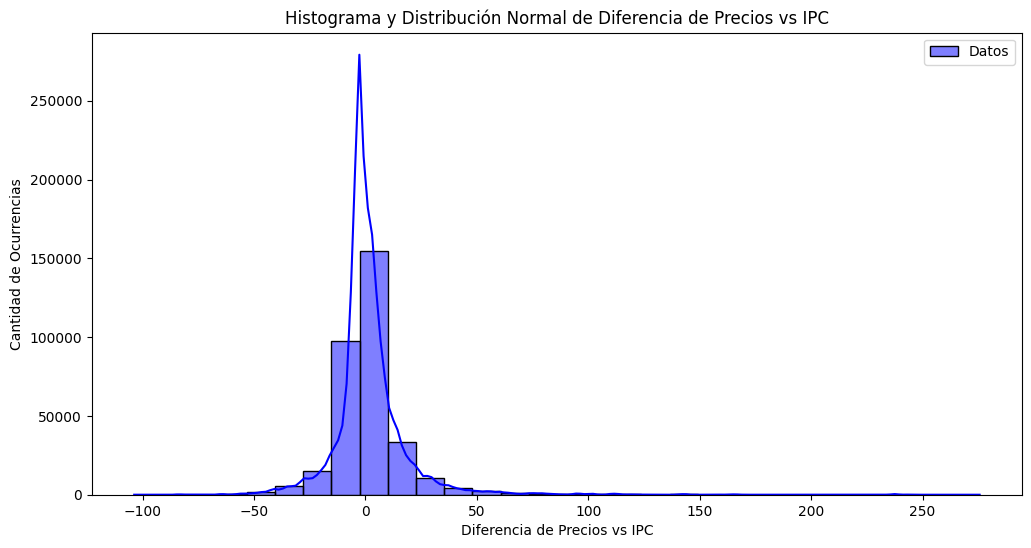

In [21]:

# Graficar un histograma de 'Pre_VarMesPor'
plt.figure(figsize=(12, 6))
sns.histplot(df_Precios6t['Pre_DifVarMesPorAbs'], bins=30, kde=True, color='blue', label='Datos')

# Ajuste de la distribución normal a los datos
media = df_Precios6t['Pre_DifVarMesPorAbs'].mean()
desviacion_estandar = df_Precios6t['Pre_DifVarMesPorAbs'].std()
x = np.linspace(media - 3*desviacion_estandar, media + 3*desviacion_estandar, 100)
pdf = norm.pdf(x, media, desviacion_estandar)

plt.xlabel('Diferencia de Precios vs IPC')
plt.ylabel('Cantidad de Ocurrencias')
plt.title('Histograma y Distribución Normal de Diferencia de Precios vs IPC')
plt.legend()

plt.show()

↑↑↑ <small>Se observa una distribución que entre el 0 y el 10% es mayoritaria, en línea con las conclusiones previas</small> ↑↑↑ 

#### ↓↓↓ Visualización según cadena de comercios ↓↓↓

<function matplotlib.pyplot.show(close=None, block=None)>

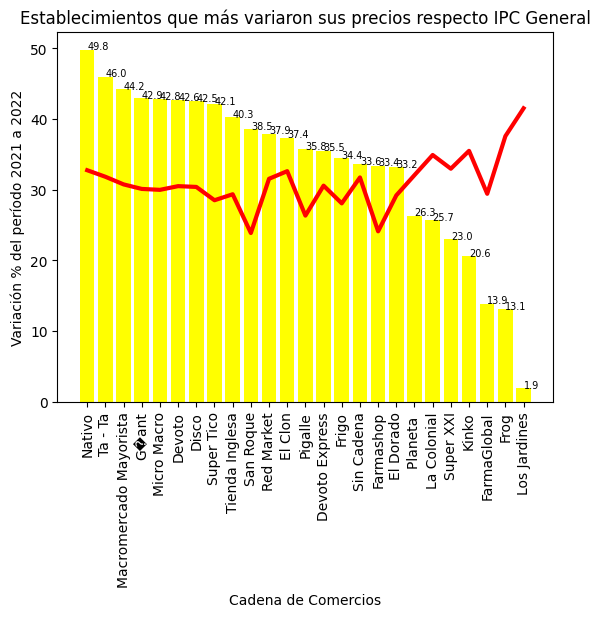

In [22]:
### Subgrupo 'cadena' de comercios
df_PreciosAgrupaEcad_Periodo_G = df_Precios6t.groupby(['cadena']).agg({'Pre_VarAcuPor': 'mean', 'Ind_VarAcuPor': 'mean'}).reset_index()
df_PreciosAgrupaEcad_Periodo_G = df_PreciosAgrupaEcad_Periodo_G.sort_values('Pre_VarAcuPor' , ascending=False)
df_PreciosAgrupaEcad_Periodo_G = df_PreciosAgrupaEcad_Periodo_G.dropna()

plt.bar(df_PreciosAgrupaEcad_Periodo_G['cadena'], df_PreciosAgrupaEcad_Periodo_G['Pre_VarAcuPor'], color="yellow")
plt.xticks(df_PreciosAgrupaEcad_Periodo_G['cadena'])
#plt.tight_layout()

# Agrega la línea fija de inflación
x = df_PreciosAgrupaEcad_Periodo_G['cadena']
y = df_PreciosAgrupaEcad_Periodo_G['Ind_VarAcuPor']
plt.plot(x, y, linestyle='-', linewidth=3, color='red')

plt.xlabel('Cadena de Comercios')
plt.ylabel('Variación % del período ' + str(v_AñosContextoR[1]) + ' a ' + str(v_AñosContextoR[-1]))
plt.title('Establecimientos que más variaron sus precios respecto IPC General')
plt.xticks(rotation='vertical')
#plt.figure(figsize=(10, 10))

for i in range(len(df_PreciosAgrupaEcad_Periodo_G)):
    plt.text(df_PreciosAgrupaEcad_Periodo_G['cadena'].iloc[i], df_PreciosAgrupaEcad_Periodo_G['Pre_VarAcuPor'].iloc[i], round(df_PreciosAgrupaEcad_Periodo_G['Pre_VarAcuPor'].iloc[i],1), fontsize=7)

plt.show


↑↑↑ <small> Insight: Se observa que el incremento de precios de la mayoría de las cadenas de comercios es mayor que el IPC </small>

↓↓↓ <small>Se propone a continuación un gráfico aplicando el algoritmo de clasificación k-means con la finalidad de agrupar los comercios en función de su ubicación geográfica </small> ↓↓↓

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


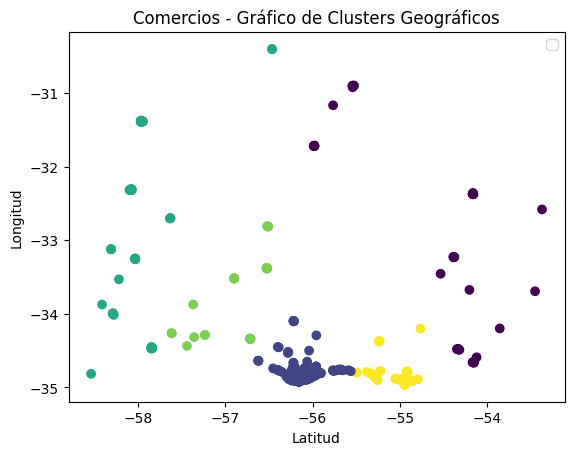

In [23]:
df_EstablecimientosXY = df_EstablecimientosRes.dropna(subset=['long', 'lat'])

# Creo una matriz de distancia utilizando la fórmula de Haversine (digamos diagonal)
dist_matrix = haversine_distances(
    df_EstablecimientosXY[['lat_rad', 'lon_rad']].values, df_EstablecimientosXY[['lat_rad', 'lon_rad']].values
) * 6371  # esto lo convierte a kilómetros (es el radio de la tierra)

# Aplico el algoritmo de K-means para agrupar los comercios según su ubicación
kmeans = KMeans(n_clusters=6, random_state=42)
df_EstablecimientosXY['cluster'] = kmeans.fit_predict(dist_matrix)

plt.scatter(df_EstablecimientosXY['lat'], df_EstablecimientosXY['long'], c=df_EstablecimientosXY['cluster'])
plt.xlabel('Latitud')
plt.ylabel('Longitud')
plt.title('Comercios - Gráfico de Clusters Geográficos')
plt.legend()
plt.show()

↑↑↑ <small>Insight: claramente se observa la mayor agrupación de comercios evaluados en Montevideo y Canelones, más particularmente en la Costa de Oro. Luego en el resto de los departamentos se ven más dispersos, con mayor concentración en las capitales departamentales.</small> 

#### ↓↓↓ Visualización según Departamento (Provincia) ↓↓↓

<function matplotlib.pyplot.show(close=None, block=None)>

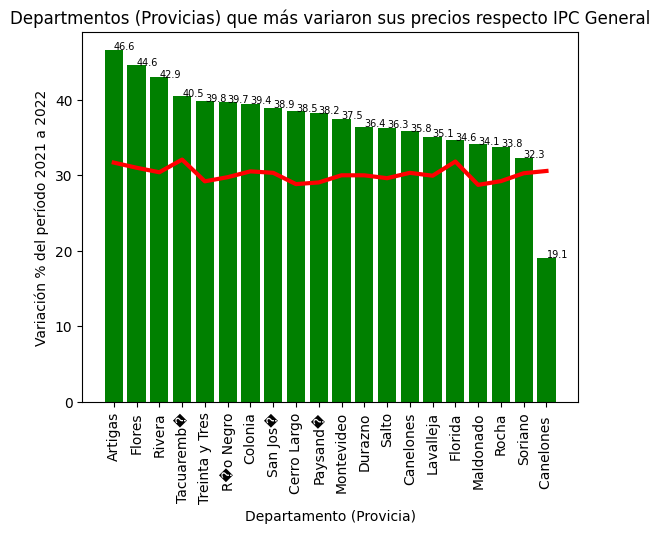

In [24]:
### Departamento (provincia) de los comercios
df_PreciosAgrupaEcad_Periodo_G = df_Precios6t.groupby(['depto']).agg({'Pre_VarAcuPor': 'mean', 'Ind_VarAcuPor': 'mean'}).reset_index()
df_PreciosAgrupaEcad_Periodo_G = df_PreciosAgrupaEcad_Periodo_G.sort_values('Pre_VarAcuPor' , ascending=False)
df_PreciosAgrupaEcad_Periodo_G = df_PreciosAgrupaEcad_Periodo_G.dropna()

plt.bar(df_PreciosAgrupaEcad_Periodo_G['depto'], df_PreciosAgrupaEcad_Periodo_G['Pre_VarAcuPor'], color="green")
plt.xticks(df_PreciosAgrupaEcad_Periodo_G['depto'])
#plt.tight_layout()

# Agrega la línea fija de inflación
x = df_PreciosAgrupaEcad_Periodo_G['depto']
y = df_PreciosAgrupaEcad_Periodo_G['Ind_VarAcuPor']
plt.plot(x, y, linestyle='-', linewidth=3, color='red')

plt.xlabel('Departamento (Provicia)')
plt.ylabel('Variación % del período ' + str(v_AñosContextoR[1]) + ' a ' + str(v_AñosContextoR[-1]))
plt.title('Departmentos (Provicias) que más variaron sus precios respecto IPC General')
plt.xticks(rotation='vertical')
#plt.figure(figsize=(10, 10))

for i in range(len(df_PreciosAgrupaEcad_Periodo_G)):
    plt.text(df_PreciosAgrupaEcad_Periodo_G['depto'].iloc[i], df_PreciosAgrupaEcad_Periodo_G['Pre_VarAcuPor'].iloc[i], round(df_PreciosAgrupaEcad_Periodo_G['Pre_VarAcuPor'].iloc[i],1), fontsize=7)

plt.show

↑↑↑ <small> Insight: Solamente en un departamento los precios reportados por los comercios estuvieron por debajo del IPC </small>

#### Visualización de la variación de precios acumulada por Ubicación Geográfica

<small>Como complemento de las visualizaciones anteriores, y a efectos de ofrecer un mapa visual del incremento acumulado de precios por ubicación geográfica se propone un interesante mapa de calor.<br>
En color más intenso los comercios y zonas donde la inflación de los productos es más importante.</small>

In [25]:

df_EstablecimientosXY1 = df_Precios5a.groupby(['id_Estab', 'long', 'lat'])[['Pre_VarAcuPor']].mean().reset_index()
df_EstablecimientosXY3 = df_EstablecimientosXY1.dropna(subset=['Pre_VarAcuPor'])

# Para situar el mapa inicial
folium_hmap = folium.Map(location=[-35, -55],
                        zoom_start=5,
                        tiles="OpenStreetMap")

hm_wide = HeatMap( list(zip(df_EstablecimientosXY3['long'], df_EstablecimientosXY3['lat'], df_EstablecimientosXY3['Pre_VarAcuPor'])),
                   min_opacity=0.6,
                   max_opacity=1,
                   radius=10, blur=10,
                   max_zoom=15,
                 )

folium_hmap.add_child(hm_wide)

### ↓↓↓ Modelo de proyección de precios futuros ↓↓↓
<small>Se propone un modelo de regresión lineal para predecir el precio futuro de un producto<br>

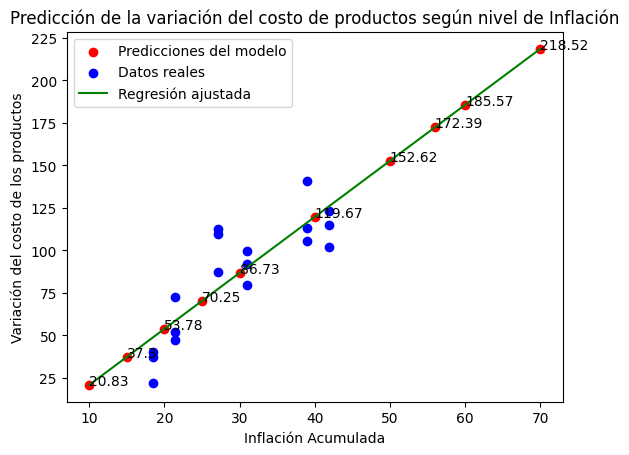

In [26]:

### Parámetros
v_productos = [1,2,3]   # codigos de productos que entraría el operador (p.e. 1 al 3: Aceite de Girasol)
v_AnoMes_FiltroP = [Cod_AnoMes for Cod_AnoMes in v_AnoMes_Filtro if Cod_AnoMes not in v_excluye_NuevosDatos]  # Excluyo nuevos datos
df_nuevoRegre = df_Precios6p[(df_Precios6p['Cod_AnoMes'].isin(v_AnoMes_FiltroP)) & (df_Precios6p['id_Producto'].isin(v_productos))][['Pre_VarAcuPor', 'Ind_VarAcuPor']]  # Filtro productos y año/mes
v_entrada =[[10],[15],[20],[25],[30],[40],[50],[56],[60],[70]]  # valores de inflación ACUMULADA que ingresaría un usuario

# Dataframe auxiliar de regresión lineal para visualización individual de productos
df_nuevoRegreTmp = df_Precios6p[(df_Precios6p['Cod_AnoMes'].isin(v_AnoMes_FiltroP)) & (df_Precios6p['id_Producto'].isin(v_productos))][['Cod_AnoMes', 'id_Producto', 'Precio' ,'Pre_VarAcuPor', 'Ind_VarAcuPor']]  # Filtro productos y año/mes
###-----------------------------

v_tipoRegresion = linear_model.LinearRegression()  # traigo el creador del modelo

### el modelo que traje requiere un formato que contemple multiples vectores, en este caso sólo 1 pero hay que adapatar la forma
v_Ind_Var12Acum = df_nuevoRegre["Ind_VarAcuPor"].values.reshape((-1,1))

### parámetros: variable indep. (tiempo/inflación), variable depen. (incremento precio)
v_modeloRegresion = v_tipoRegresion.fit(v_Ind_Var12Acum, df_nuevoRegre["Pre_VarAcuPor"])
#print("Interseccion (b)", v_modeloRegresion.intercept_) # intersección x=0
#print("Pendiente (m)", v_modeloRegresion.coef_)  # pendiente de la recta

v_modeloRegresion.predict(v_entrada) # me predice valores

plt.title("Predicción de la variación del costo de productos según nivel de Inflación")
plt.xlabel("Inflación Acumulada")
plt.ylabel("Variación del costo de los productos")

# Predicciones del modelo:
plt.scatter(v_entrada, v_modeloRegresion.predict(v_entrada), color = "red", label="Predicciones del modelo")
for i, valor in enumerate(v_modeloRegresion.predict(v_entrada)):
    plt.text(v_entrada[i][0], valor, round(valor,2))
    #print(valor)

# Info real
plt.scatter(df_nuevoRegre["Ind_VarAcuPor"], df_nuevoRegre["Pre_VarAcuPor"], color= "blue", label="Datos reales")

# regresión ajustada:
plt.plot(v_entrada, v_modeloRegresion.predict(v_entrada), color = "green", label="Regresión ajustada")

plt.legend()
plt.show()


<small>Insight: Se observa que un modelo de regresión lineal podría ser adecuado para predecir el precio futuro de un producto ya que la evolución de precios a traves de los años vistos es relativamente estable y lineal<br>

### Algoritmo de clasificación

<small>Se propone un algoritmo de clasificación para predecir si un producto subirá más, igual o menos que el IPC<br>
Dada la inflación relativamente baja y estable se propondrá 3 categorías de aumento de precios: Alta, Neutra y Baja<br>
En otro contexto de inflación se podría segmentar este incremento en más categorías<br>

↓↓↓ <small>Con el fin de no distorsionar el modelo se propone eliminar los outliers de la variable objetivo<br>
A modo de hiperparámetro "previo" se excluyen los extremos en un 5% de la muestra. Se debería ajustar según la necesidad o el producto, o incluso no aplicar esta segmentación previa</small> ↓↓↓

In [27]:

df_Precios6pt = df_Precios5a.copy()
df_Precios6pt.dropna(inplace=True)

# Quitar outliers  ------------------- INICIO APARTADO
percentil_bajo = df_Precios6pt['Pre_VarMesPor'].quantile(0.05)
percentil_alto = df_Precios6pt['Pre_VarMesPor'].quantile(0.95)

umbral_inferior = percentil_bajo - 1.5 * (percentil_alto - percentil_bajo)
umbral_superior = percentil_alto + 1.5 * (percentil_alto - percentil_bajo)

df_Precios7pt = df_Precios6pt[(df_Precios6pt['Pre_VarMesPor'] >= umbral_inferior) & (df_Precios6pt['Pre_VarMesPor'] <= umbral_superior)]

#-------------------------------------- FIN APARTADO
print("Chequeo de la cantidad de registros excluidos por la eliminación de outliers")
print("Cantidad previa de registros: ", df_Precios6pt.shape[0])
print("Cantidad actual de registros: ", df_Precios7pt.shape[0])

Chequeo de la cantidad de registros excluidos por la eliminación de outliers
Cantidad previa de registros:  477473
Cantidad actual de registros:  474495


↓↓↓ <small>A fin de acotar el análisis se propone trabajar con un grupo específico de productos, en este caso, a modo de ejemplo se propone la siguiente segmentación:
<br>
- División "01": Alimentos y Bebidas no Alchohólicas
</small> ↓↓↓

In [28]:
df_Precios8 = df_Precios7pt[(df_Precios7pt['Division'] == '01')] #  & df_Precios7pt['Año'].isin([2020,2021,2022])
del df_Precios7pt
print("Chequeo de que la cantidad de registros sea significativa:")
print("Cantidad actual de registros: ", df_Precios8.shape[0])

Chequeo de que la cantidad de registros sea significativa:
Cantidad actual de registros:  263806


In [29]:
df_Precios8b = df_Precios8[['id_Producto', 'Año', 'Mes', 'id_depto', 'Clase', 'Subclase', 'cajas', 'Pre_VarMesPor', 'Ind_VarMesPor', 'Pre_DifVarMesPorAbs', 'Pre_DifVarAcuPorAbs']]
del df_Precios8

↓↓↓ <small>A continuación se propone un modelo de clasificación con el algoritmo de KNN (K-Nearest Neighbors) con la finalidad de predecir si un producto subirá más, igual o menos que el IPC<br>
Para esto se hacen los siguientes pasos: (ver en los comentarios de la líneas)

In [30]:
# Se calcula la media a fin de fijar el entorno de los umbrales
v_media = df_Precios8b['Pre_DifVarMesPorAbs'].mean()

# Se establecen los umbrales para 3 categorías -10/+10 entorno a la media sería neutro
valor_limite_bajo = v_media * 0.90
valor_limite_neutro = v_media * 1.10

umbrales = [-float("inf"), valor_limite_bajo, valor_limite_neutro, float("inf")]

# Etiquetas para las categorías (-1: bajo, 0: neutro, 1: alto)
Categoria = [-1, 0, 1]

# Aplica la categorización a la columna 'Pre_DifVarMesPorAbs'
df_Precios8b['Categoria'] = pd.cut(df_Precios8b['Pre_DifVarMesPorAbs'], bins=umbrales, labels=Categoria)

#### Algoritmo de clasificiación: K-NN (vecinos más cercanos)

<small>A continuación se propone clasificar en las categorías establecidas el aumento de precio respecto a la inflación. Se verificará si este modelo es capaz de predecir en función de éstas variables:<br>
</small> ↓↓↓

In [31]:
# Se divide el conjunto de datos en características (X) y etiquetas (y)
X = df_Precios8b[["cajas", "id_depto"]]
y = df_Precios8b["Categoria"]

# Se dividen los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Se normaliza las características
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

knn = KNeighborsClassifier(n_neighbors=5) # Crea el clasificador, pruebo con el hiperparámetro=5

knn.fit(X_train, y_train)  # Entrenamiento del modelo

y_pred = knn.predict(X_test)  # Prediccionies

# Calcula la precisión del modelo:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy del modelo K-NN: {:.2f}".format(accuracy))

Accuracy del modelo K-NN: 0.51


↑↑↑ <small>El modelo calcula con una precisión moderada la categoría de aumento de precios: "Bajo, Neutro, Alto". Podría ser mejor pero al ser en rangos de inflación bajos las medidas de dispersión de precios son menores y menos distintivas<br>
Breve explicación:<br>
Accuracy_score: mide la proporción de predicciones correctas en el conjunto de datos en general. Es la relación entre el número total de predicciones correctas (verdaderos positivos y verdaderos negativos) y el número total de predicciones realizadas.

↓↓↓ <small>Otras medidas estadísticas:
</small> ↓↓↓

In [32]:
precision = precision_score(y_test, y_pred, average='weighted')
print("Precisión del modelo K-NN: {:.2f}".format(precision))

Precisión del modelo K-NN: 0.50


↑↑↑ <small>
Precision_score: se centra en las predicciones positivas y mide la proporción de predicciones positivas que son verdaderamente positivas (verdaderos positivos) 

In [33]:
recall = recall_score(y_test, y_pred, average='weighted')
print("Recall: {:.2f}".format(recall))

Recall: 0.51


↑↑↑ <small>
Breve explicación:<br>
Recall: es la proporción de predicciones positivas correctas con respecto al número total de casos positivos reales
</small>

In [34]:
f1 = f1_score(y_test, y_pred, average='weighted')
print("F1-Score: {:.2f}".format(f1))

F1-Score: 0.51


↑↑↑ <small>
Breve explicación:<br>
F1-Score: es la media que armoniza las metricas de precisión y recall y proporciona un equilibrio entre ambas
</small>

#### Algoritmo de clasificiación: Random Forest
<small>Con los misma información anterior se aplica este modelo para evaluar si mejora los resultados anteriores.<br>
No es estrictamente necesario hacer una nueva división de datos de entrenamiento/prueba o normalizar los datos

In [35]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)  # Creo el modelo

rf.fit(X_train, y_train)  # Entreno el modelo

y_pred_rf = rf.predict(X_test) # Predicciones en los datos de prueba

# Cálculo de la precisión del modelo:
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print("Accuracy del modelo Random Forest: {:.2f}".format(accuracy_rf))

Accuracy del modelo Random Forest: 0.57


↑↑↑ <small>
El modelo de clasificación Random Forest es sensiblemente mejor que K-NN. Se deja planteado ambos ya que la diferencia es muy pequeña y puede cambiar si se parametriza un grupo o un producto en particular.<br>
Cabe aclarar: Si aplicamos el otro método de clasificación dado que fue regresión logística los resultados son similares a Random Forest.
</small>

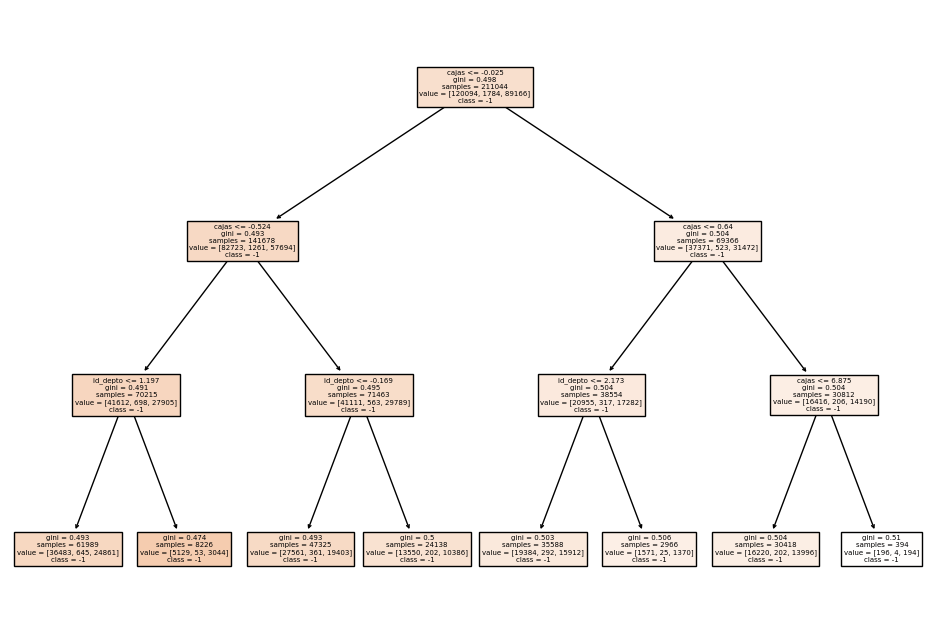

In [36]:
from sklearn.tree import plot_tree
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier(max_depth=3)
model.fit(X_train, y_train)

plt.figure(figsize=(12, 8))
plot_tree(model, feature_names=['cajas', 'id_depto'], class_names=['-1', '0', '1'], filled=True)
plt.show()

↓↓↓ <small>Se propone, bajo los mismos parámetros, comparar la precisión de K-NN y Decision Tree</small> ↓↓↓

In [37]:
# Se divide el conjunto de datos en características (X) y etiquetas (y)
X = df_Precios8b[["cajas", "id_depto"]]
y = df_Precios8b["Categoria"]

# Se dividen los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Se normaliza las características de la misma manera para ambos clasificadores
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Clasificador K-NN
knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)
accuracy_knn = accuracy_score(y_test, y_pred_knn)

# Clasificador DecisionTree
model = DecisionTreeClassifier(max_depth=3)
model.fit(X_train, y_train)
y_pred_tree = model.predict(X_test)
accuracy_tree = accuracy_score(y_test, y_pred_tree)

# Resultados
print("Accuracy del modelo K-NN: {:.2f}".format(accuracy_knn))
print("Accuracy del modelo DecisionTree: {:.2f}".format(accuracy_tree))

Accuracy del modelo K-NN: 0.55
Accuracy del modelo DecisionTree: 0.57


<small>La diferencia es muy pequeña, pero se observa que Decision Tree es ligeramente mejor que K-NN, aunque dependiendo del hiperparámetro que se elija donde también está en juego el tipo de producto </small>

↓↓↓ <small>Se puede obtener dinámicamente el umbral, por ejemplo, para los 2 primeros niveles y desnormalizar el valor para en este caso obtener la cantidad de cajas (indicador el tamaño del comercio)</small> ↓↓↓

In [38]:

umbral_normalizado1 = model.tree_.threshold[0]
umbral_normalizado2 = model.tree_.threshold[1]  # Se toma el umbral del segundo nodo a modo de ejemplo (muestra)

print("Umbral normalizado (Q cajas):", umbral_normalizado1)

mean_cajas = df_Precios8b["cajas"].mean()
std_cajas = df_Precios8b["cajas"].std()
min_cajas = df_Precios8b["cajas"].min()
max_cajas = df_Precios8b["cajas"].max()

umbral_desnormalizado1 = (umbral_normalizado1 * std_cajas) + mean_cajas   # Desnormalizar el umbral
umbral_desnormalizado2 = (umbral_normalizado2 * std_cajas) + mean_cajas

print("Cantidad de cajas mínimas:", min_cajas)
print("Cantidad de cajas máximas:", max_cajas)
print("Cantidad de cajas 1er nodo:", umbral_desnormalizado1)
print("Cantidad de cajas 2do nodo:", umbral_desnormalizado2)


Umbral normalizado (Q cajas): -0.025375597178936005
Cantidad de cajas mínimas: 1.0
Cantidad de cajas máximas: 62.0
Cantidad de cajas 1er nodo: 6.500238733763797
Cantidad de cajas 2do nodo: 3.5034903669522555


↑↑↑ <small>El valor 'Gini' ronda el 50%, esto significa que aproximadamente la mitad de las muestras pertenecen a una clase y la mitad a la otra.<br>
En principio parece pobre la precisión del modelo, pero puede ser un indicativo también, de que el tamaño del comercio no determina el umbral de variación de precios, información que también puede ser relevante<br>
Se podría intentar alguna agrupación de comercios en función del tamaño, sería tarea de algún profesional de contabilidad o económia proponerla en función de criterios económicos y el cientista de datos tratar encontrar algún algoritmo para trabajarla que arroje información en función de un interés establecido</small>

↓↓↓ <small>A continuación se propone otra forma de visualización, a través de la correlación de variables "cajas vs categoria" (donde cajas es indicativo del tamaño del comercio y categoría es indicativo del incremento de nivel de precios respecto a la inflación)</small> ↓↓↓

In [39]:
# construyo un df con las columnas que necesito para el análisis
df_extra1 = pd.DataFrame({'cajas': df_Precios8b['cajas'], 'id_depto': df_Precios8b['id_depto'], 'Categoria': df_Precios8b['Categoria']})

# Correlación de Pearson
correlacion_CC = df_extra1.groupby('id_depto')[['cajas', 'Categoria']].corr().iloc[0::2, -1] # Agrupa por departamento y calcula la correlación entre cajas y categoría

max_corr_deptos = correlacion_CC.groupby('id_depto').max() # máximo de correlación por departamento
print(max_corr_deptos)

id_depto
1.0     0.037349
2.0     0.096768
3.0     0.040817
4.0     0.048175
5.0     0.032498
6.0     0.005727
7.0     0.075162
8.0     0.087154
9.0     0.000752
10.0    0.035053
11.0    0.123041
12.0    0.071733
13.0    0.009060
14.0    0.025442
15.0    0.094615
16.0    0.085416
17.0    0.039268
18.0    0.004652
19.0    0.022668
Name: Categoria, dtype: float64


↑↑↑ <small>Insight: como se esperaba debido al resultado de los algoritmos presentados, la correlación es baja entre tamaño comercio e incremento de precios respecto a la inflación. A pesar de ello se puede decir que el departamento la mayor correlación es el nro. 11</small>

#### Verificación del modelo de Regresión Lineal
<small>Se procederá a validar el módelo propuesto de regresión lineal para predecir el precio futuro de un producto<br></small>

In [40]:
df_Precios1Post = df_PreciosPost[df_PreciosPost['Fecha'].isin(v_ultimo_DiaMes)]

df_Precios1Post['Fecha'] =  pd.to_datetime(df_Precios1Post['Fecha'], format='%Y/%m/%d')
df_Precios1Post['Año'] = df_Precios1Post['Fecha'].dt.year
df_Precios1Post['Mes'] = df_Precios1Post['Fecha'].dt.month
df_Precios1Post['Cod_AnoMes'] = (df_Precios1Post['Fecha'].dt.year * 100) + df_Precios1Post['Fecha'].dt.month  # LLave para el merge

# Me aseguro que cada producto y comercio tenga solamente un precio por mes
df_Precios1Post = df_Precios1Post.groupby(['id_Producto' , 'id_Estab','Cod_AnoMes', 'Año', 'Mes'])['Precio'].mean().reset_index()

### Me aseguro que estos campos tengan el tipo de dato correcto
df_Precios1Post.loc[:, 'id_Estab'] = df_Precios1Post['id_Estab'].astype('int16')
df_Precios1Post.loc[:, 'id_Producto'] = df_Precios1Post['id_Producto'].astype('int16')
df_Precios1Post = df_Precios1Post[df_Precios1Post['Cod_AnoMes'].isin(v_AnoMes_Filtro)]
#del df_Precios0

print("Cantidad de registors incorporados: ", df_Precios1Post.shape[0])


Cantidad de registors incorporados:  61033


In [41]:
# Me quedo sólo con los productos en común, es decir, excluyo los nuevos para no distorsionar el análisis
productos_en_df_Precios1 = df_Precios0a['id_Producto'].unique()     # DF con productos sin nuevos datos

df_Precios1Post_filtrado = df_Precios1Post[df_Precios1Post['id_Producto'].isin(productos_en_df_Precios1)]

df_Precios1Post_tmp = pd.concat([df_Precios1, df_Precios1Post_filtrado], ignore_index=True)
del df_Precios0a, df_Precios1  # Libero memoria

# Estas líneas es para el análisis de la totalidad de productos pero excluyendo los nuevos para no distorsionar el análisis.

Variables para visualización y chequeo:
Indice Base: 66.20451934124858 del periodo: 201712
Indice Final: 103.22262235 del periodo: 202306
Indice Acum.: 55.91476741631951

Data nueva a incorporar:
     Pre_VarAcuPor  Ind_VarAcuPor
160      35.449303      55.914767
167      39.517403      55.914767


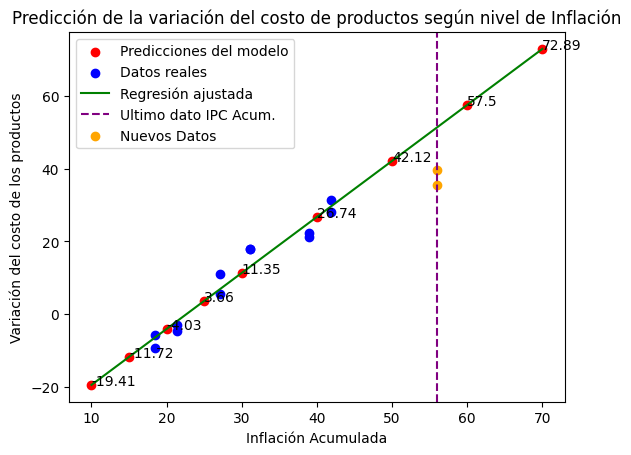

In [42]:

v_productos = [24 ,25 ]   # codigos de productos que entraría el operador (por ejemplo 24 y 25: Azúcar Blanco)

v_AnoMes_FiltroP = [Cod_AnoMes for Cod_AnoMes in v_AnoMes_Filtro if Cod_AnoMes not in v_excluye_NuevosDatos]  # Excluyo nuevos datos
df_nuevoRegre = df_Precios6p[(df_Precios6p['Cod_AnoMes'].isin(v_AnoMes_FiltroP)) & (df_Precios6p['id_Producto'].isin(v_productos))][['Pre_VarAcuPor', 'Ind_VarAcuPor']]  # Filtro productos y año/mes
v_entrada =[[10],[15],[20],[25],[30],[40],[50],[60],[70]]  # valores de inflación ACUMULADA que ingresaría un usuario

v_nuevoAnoMes = 202306
df_nuevoRegrePost = df_Precios6p[(df_Precios6p['Cod_AnoMes'].isin([v_nuevoAnoMes])) & (df_Precios6p['id_Producto'].isin(v_productos))][['Pre_VarAcuPor', 'Ind_VarAcuPor']]

# Información extra para mostrar:
ind_base = df_ipcGral[df_ipcGral['Cod_AnoMes'] == min_per]['Indice'].values[0]
ind_final = df_ipcGral[df_ipcGral['Cod_AnoMes'] == v_nuevoAnoMes]['Indice'].values[0]
ind_ipcNuevo = (ind_final - ind_base) / ind_base * 100

v_tipoRegresion = linear_model.LinearRegression()  # traigo el creador del modelo
v_Ind_Var12Acum = df_nuevoRegre["Ind_VarAcuPor"].values.reshape((-1,1))

### parámetros: variable indep. (tiempo/inflación), variable depen. (incremento precio)
v_modeloRegresion = v_tipoRegresion.fit(v_Ind_Var12Acum, df_nuevoRegre["Pre_VarAcuPor"])

v_modeloRegresion.predict(v_entrada) # me predice valores

plt.title("Predicción de la variación del costo de productos según nivel de Inflación")
plt.xlabel("Inflación Acumulada")
plt.ylabel("Variación del costo de los productos")

# Predicciones del modelo:
plt.scatter(v_entrada, v_modeloRegresion.predict(v_entrada), color = "red", label="Predicciones del modelo")
for i, valor in enumerate(v_modeloRegresion.predict(v_entrada)):
    plt.text(v_entrada[i][0], valor, round(valor,2))
    #print(valor)

# Info real
plt.scatter(df_nuevoRegre["Ind_VarAcuPor"], df_nuevoRegre["Pre_VarAcuPor"], color= "blue", label="Datos reales")

# regresión ajustada:
plt.plot(v_entrada, v_modeloRegresion.predict(v_entrada), color = "green", label="Regresión ajustada")

# Agrego los nuevos datos del nuevo semestre
plt.axvline(x=ind_ipcNuevo, color='purple', linestyle='--', label="Ultimo dato IPC Acum.")
df_nuevoRegrePost = df_nuevoRegrePost.assign(Ind_VarAcuPor=ind_ipcNuevo)
plt.scatter(df_nuevoRegrePost["Ind_VarAcuPor"], df_nuevoRegrePost["Pre_VarAcuPor"], color='orange', label="Nuevos Datos")

print("Variables para visualización y chequeo:")
print("Indice Base: " + str(ind_base) + " del periodo: " + str(min_per))
print("Indice Final: " + str(ind_final) + " del periodo: " + str(v_nuevoAnoMes))
print("Indice Acum.: " + str(ind_ipcNuevo))
print("")
print("Data nueva a incorporar:")
print(df_nuevoRegrePost.head(10))

plt.legend()
plt.show()



<small>Insight: los puntos amarillos son datos nuevo, que el modelo no vió anteriormente, en este caso del primer semestre 2023.<br>
Es decir, se armó un modelo con datos de 2017 a 2022 y se lo validó con datos de 2023<br></small>

In [43]:

# Información auxiliar a modo de chequeo y visualizar todos los productos
v_AnoMes = [201712, 202212, 202306]
df_nuevoRegrePostResu = df_Precios6p[(df_Precios6p['Cod_AnoMes'].isin(v_AnoMes)) ]


In [44]:
end_time = datetime.datetime.now()
print("Fin de la ejecución:", end_time)
print("Duración de la ejecución hh/mm/ss:", (end_time - start_time))

Fin de la ejecución: 2023-10-22 19:44:05.908958
Duración de la ejecución hh/mm/ss: 0:01:58.493308
